In [173]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sys
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import recall_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

sys.path.insert(0, '../Code/')
from Plots import plt_validation_curve

ATENCIÓN: Disponible en sklearn 1.5 o superior

In [174]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [175]:

outcome = 'outcome'
df = pd.read_csv("../datasets/raw_loan_data.csv.gz")
df.loc[df[outcome]=="paid off",[outcome]] = "aPaidOff"
le = LabelEncoder()
le.fit(df[outcome])
df.loc[:,[outcome]] = le.transform(df[outcome]).astype(int)

df.drop(columns=["Unnamed: 0", "status"], inplace=True)
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
col_num = ["dti", "revol_bal", "revol_util", "open_acc"]
dfc = df.copy()
dfc.loc[:, col_num] = StandardScaler().fit_transform(df[col_num])
X = dfc[predictors]
y = dfc[outcome].astype(int)

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
df.loc[:,'borrower_score_'] = knn.predict_proba(X)[:, 1]


del dfc



In [176]:
clf1 = True
X = pd.get_dummies(df[df.columns.drop(outcome)])
y = df[outcome].astype(int) #Arreglar esto
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)
#No selecciono el mejor clasificador porque demora mucho y no aporta a la idea que se quiere explicar
if clf1==True:
    model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)
else:
    model = RandomForestClassifier(criterion='log_loss', max_depth=8, max_features=None,
                        min_samples_leaf=2, min_samples_split=14,
                        n_estimators=90)

model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)

La curva ROC es una buen herramienta para analizar el comportamiento general del modelo a medida que se avanza en el porcentaje de registros y verificar no solo el area bajo la curva sino tambien la existencia de un lugar en donde el modelo se vuelve peor que el azar.

No se debe descargar un escenario donde las reglas del negocio impongan un punto de corte en función de los costos asociados principalmente a comenter errores

Podemos suponer un escenario donde el coste esperado de incumplimiento de un préstamo es C, por otro lado, el rendimiento de un préstamo que se pagará es R. Finalmente el rendimiento esperado de un préstamo en general es:
𝑅𝑒𝑛𝑑𝑖𝑚𝑖𝑒𝑛𝑡𝑜=𝑃(𝑌=0)𝑅+𝑃(𝑌=1)𝐶
En lugar de simplemente etiquetar como pagado o no pagado, o determinar la propensión de incumplimiento podemos determinar si el prestamos tiene un rendimiento esperado positivo. Allí estará el punto de corte.

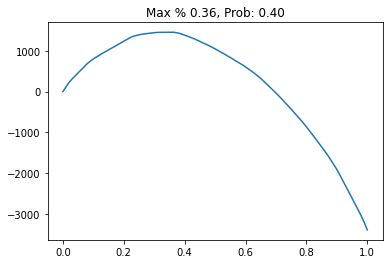

In [177]:
paidOff = 1
default = 1.5
y_df = pd.DataFrame({"y_test":y_test, 
                     "y_proba_c0":model.predict_proba(X_test)[:, 0],
                     "y_proba_ci":model.predict_proba(X_test)[:, 1]})
y_df["Rendimiento"] = y_df["y_proba_c0"]*paidOff - y_df["y_proba_ci"]*default
y_df = y_df.sort_values(by="Rendimiento", ascending=False)
thresholds = np.linspace(0, 1, 100)
rends = [np.sum(y_df.iloc[:int(t * y_df.shape[0]), :]["Rendimiento"]) for t in thresholds]
np.max(rends)
data_percent = thresholds[np.argmax(rends)]
plt.title("Max % {:.2f}, Prob: {:.2f}".format(data_percent, 
                                              y_df.iloc[int(data_percent * y_df.shape[0]), :]["y_proba_ci"]))
plt.plot(thresholds, rends)


La misma idea se puede extender a una matriz que me indique exactamente los costos o ganancias de cada situación. Se multiplica luego por la matriz de confusion.


In [233]:
scoring = {}
def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    #Para que la matriz de confusión sea como figura en los textos
    cm = np.rot90(cm, 2)
    
    gain_matrix = np.array(
        [
            [0, -2],  # -1 gain for false positives
            [-1, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)

pos_label = 1
neg_label = 0

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

scoring = {
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(recall_score, pos_label=pos_label),
    "cost_gain": make_scorer(
        credit_gain_score, greater_is_better=True, neg_label=neg_label, pos_label=pos_label
    ),
}


Con los costos y ganancias asociados...

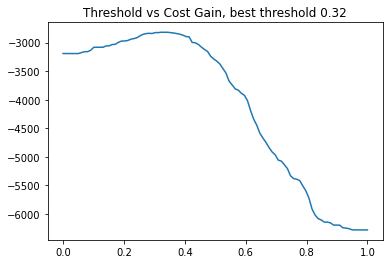

In [234]:
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
plt.plot(tuned_model.cv_results_['thresholds'], tuned_model.cv_results_['scores'])
plt.title("Threshold vs Cost Gain, best threshold {:.2f}".format(tuned_model.best_threshold_))
plt.show()


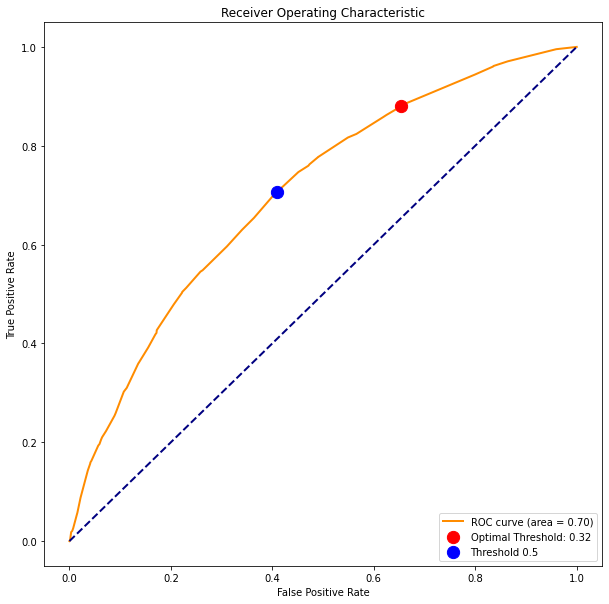

In [238]:

plt.figure(figsize=(10, 10))
best_threshold= tuned_model.best_threshold_
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# Buscar el índice del umbral óptimo

#Busco el mas cercano
idx_op = np.abs(thresholds - best_threshold).argmin()

idx_05 = (np.abs(thresholds - 0.5)).argmin()


plt.scatter(fpr[idx_op], tpr[idx_op], color='red', s=150 ,label='Optimal Threshold: %0.2f' % best_threshold, zorder=5)
plt.scatter(fpr[idx_05], tpr[idx_05], color='blue', s=150, label='Threshold 0.5', zorder=5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [239]:
print(f"Metrica definida por el negocio: {scoring['cost_gain'](tuned_model, X_test, y_test)}")

Metrica definida por el negocio: -6046


Otro escenario hipotetico. Cada cliente pagador al que no le entrego el credito me sale -100 (Oportunidad de ganar ese dinero), cada cliente no pagador me cuesta 1000. ¿Cual deberia ser mi punto óptimo de corte?

In [182]:
def myscore(y_true, y_pred):
    cost_fp = -1.5
    cost_fn = 0
    cost_tp = 1
    cost_tn = 0

    fp = np.sum((y_pred == 1) & (y_true == 0))  # False positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False negatives
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True positives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True negatives
    
    return  (fp * cost_fp) + (fn * cost_fn) + (tp * cost_tp) + (tn * cost_tn)
    
custom_scorer = make_scorer(myscore)

Curva de costo

In [183]:
# Función para calcular los costos de FP y FN en un punto de corte
def calculate_th_costs(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    return myscore(y_true, y_pred)

In [184]:
y_proba = model.predict_proba(X_test)[:, 1]
y_df = pd.DataFrame({"y_test":y_test, "y_proba":y_proba})

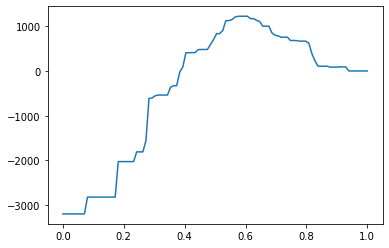

In [185]:
y_df = y_df.sort_values(by='y_proba', ascending=False)
# Generar umbrales entre 0 y 1
thresholds = np.linspace(0, 1, 100)
costs = [calculate_th_costs(y_df["y_test"], y_df["y_proba"], t) for t in thresholds]
plt.plot(thresholds, costs)

In [186]:
from sklearn.model_selection import TunedThresholdClassifierCV
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=custom_scorer,#scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.60


In [187]:
y_pred = model.predict_proba(X_test)[:,1]>0.60
print(myscore(y_test, y_pred))

1223.5
